### This notebook is for the cryotempo eolis point data processing.


In [1]:
import os
import shutil
import glob
import numpy as np
import h5py
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import pandas as pd
import netCDF4 as nc
import matplotlib.dates as mdate
from ftplib import FTP
from utils.transform_time import second_to_dyr


In [2]:
path_setp_vec = 'data/boundary/setp_zhao2022.gpkg'
path_cryotempo_points = 'data/cryotempo-points/2021/cryotempo_points_merge.h5'
path_cryotempo_tile = 'data/cryotempo-points/2021/tiles/tile_30_93.h5'
path_setp_rgi60 = 'data/rgi60/rgi60_setp.gpkg'


In [3]:
# !h5ls $path_cryotempo_points
!h5ls $path_cryotempo_tile


elevation                Dataset {1150}
inputfileid              Dataset {1150}
isSwath                  Dataset {1150}
lat                      Dataset {1150}
lon                      Dataset {1150}
time                     Dataset {1150}
uncertainty              Dataset {1150}


In [30]:
with h5py.File(path_cryotempo_points,'r') as f_cryo:
    cryotempo_points = {}
    for key in f_cryo.keys():
        cryotempo_points[key] = f_cryo[key][:]
cryotempo_points = pd.DataFrame(cryotempo_points) 


In [31]:
with h5py.File(path_cryotempo_tile,'r') as f_cryo:
    cryotempo_tile = {}
    for key in f_cryo.keys():
        cryotempo_tile[key] = f_cryo[key][:]
cryotempo_tile = pd.DataFrame(cryotempo_tile) 


In [32]:
# Dataframe meta data that describes results of query
print('Number of points =', len(cryotempo_points))
cryotempo_points.head()


Number of points = 19188


,elevation,inputfileid,isSwath,lat,lon,time,uncertainty
0,6027.748047,330607104.0,0.0,28.204727,90.180550,2021.759766,NaN
1,6024.790039,330607104.0,0.0,28.207268,90.178886,2021.759766,NaN
2,5977.909180,330607104.0,0.0,28.211777,90.169159,2021.759766,NaN
3,5838.215820,330607104.0,0.0,28.219128,90.191360,2021.759766,NaN
4,5715.527832,330607104.0,0.0,28.221684,90.159676,2021.759766,NaN


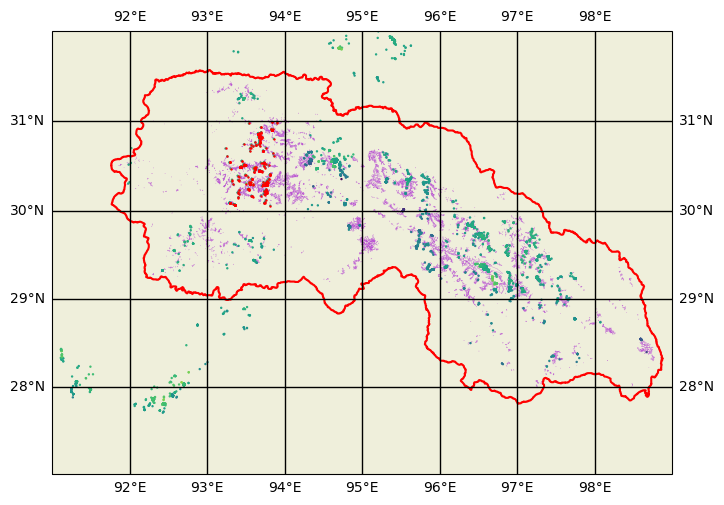

In [39]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([91, 99, 27.0, 32.0])
ax.add_feature(cfeature.LAND); 
ax.gridlines(draw_labels=True, linewidth=1, alpha=1, zorder=1, color='black')
## 1. setp boundary
shp_fea = cfeature.ShapelyFeature(Reader(path_setp_vec).geometries(), \
                      crs=ccrs.PlateCarree(), edgecolor='red', linewidth=1.5, facecolor='none')
ax.add_feature(shp_fea, zorder=0)

## 2. setp glaciers (rgi60); note: very slow
shp_fea = cfeature.ShapelyFeature(Reader(path_setp_rgi60).geometries(), \
                      crs=ccrs.PlateCarree(), edgecolor='MediumOrchid', linewidth=0.2, facecolor='none')
ax.add_feature(shp_fea, zorder=0)

# 3.1. cryotempo points data (one tile)
ax.scatter(x=cryotempo_points['lon'], y=cryotempo_points['lat'], \
                      c=cryotempo_points['elevation'], s=0.5, transform=ccrs.PlateCarree(), zorder=0)
# 3.1. cryotempo points data
ax.scatter(x=cryotempo_tile['lon'], y=cryotempo_tile['lat'], \
                      c='red', s=0.5, transform=ccrs.PlateCarree(), zorder=0)



In [ ]:
cryotempo_points_swath = cryotempo_points.loc[cryotempo_points['isSwath']==1]
cryotempo_points_swath.head()


,elevation,inputfileid,isSwath,lat,lon,time,uncertainty
6,6202.518066,5.117940e+08,1.0,28.858343,90.211334,2021.761230,23.347761
7,6172.795410,5.117940e+08,1.0,28.858330,90.211464,2021.761230,23.347761
8,6173.416016,5.117940e+08,1.0,28.858316,90.211609,2021.761230,23.347761
9,5877.633789,-1.354828e+09,1.0,30.425802,90.732834,2021.824097,23.347761
10,5875.768555,-1.354828e+09,1.0,30.425770,90.733200,2021.824097,23.347761


In [ ]:
mean_unc = np.nanmean(cryotempo_points['uncertainty'])
med_unc = np.nanmedian(cryotempo_points['uncertainty'])
std_unc = np.std(cryotempo_points['uncertainty'])


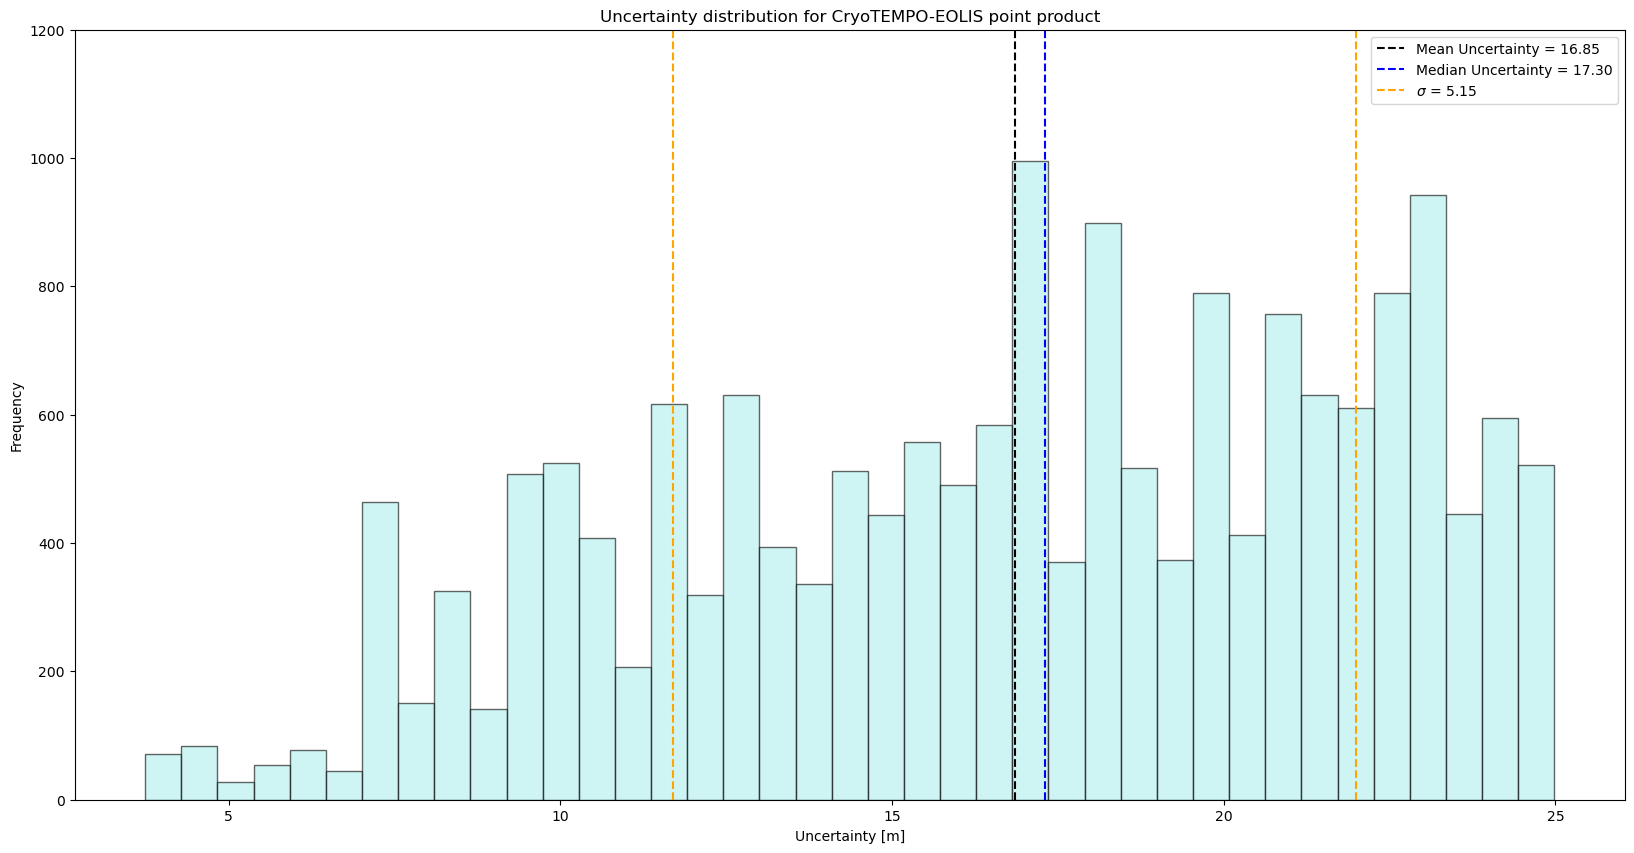

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(20,10))
bins = np.linspace(np.nanmin(cryotempo_points['uncertainty']),np.nanmax(cryotempo_points['uncertainty']),40)
a = axs.hist(cryotempo_points['uncertainty'], bins = bins, facecolor='paleturquoise', edgecolor='k', alpha=0.6)

axs.vlines(mean_unc, 0, 7.5e4, color='k', linestyle='dashed', label='Mean Uncertainty = {:0.2f}'.format(mean_unc))
axs.vlines(med_unc, 0, 7.5e4, color='b', linestyle='dashed', label='Median Uncertainty = {:0.2f}'.format(med_unc))
axs.vlines(mean_unc - std_unc, 0,1.2e3, color='orange', linestyle='dashed')
axs.vlines(mean_unc + std_unc, 0,1.2e3, color='orange', linestyle='dashed',label='$\sigma$ = {:0.2f}'.format(std_unc))

axs.set_ylim(0, 1.2e3)
axs.set_xlabel('Uncertainty [m]')
axs.set_ylabel('Frequency')
axs.set_title('Uncertainty distribution for CryoTEMPO-EOLIS point product')
plt.legend()

